In [3]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import io
import PIL
import time
import torch 
import torchvision.models as models
import unittest

from google.colab import files
from matplotlib.pyplot import imread
from PIL import Image
from torchvision import transforms
from torch import nn

device = 'gpu'

uploaded = files.upload()

Saving dog.jpg to dog.jpg
Saving cat_dir102.jpg to cat_dir102.jpg
Saving cat_dir101.jpg to cat_dir101.jpg
Saving cat_dir100.jpg to cat_dir100.jpg
Saving cat_dir99.jpg to cat_dir99.jpg
Saving cat_dir11.jpg to cat_dir11.jpg
Saving cat_dir17.jpg to cat_dir17.jpg
Saving cat_dir6.jpg to cat_dir6.jpg
Saving cat_dir16.jpg to cat_dir16.jpg
Saving cat_dir4.jpg to cat_dir4.jpg
Saving cat_dir12.jpg to cat_dir12.jpg
Saving cat_dir7.jpg to cat_dir7.jpg
Saving cat_dir5.jpg to cat_dir5.jpg
Saving cat.jpg to cat.jpg


## **Loading and visualizing the relit images**

In [0]:
data_name = "cat"
ims, ims_numpy = [], []
for d in [4, 5, 6, 7, 11, 12, 16, 17, 99, 100, 101, 102, None]:
  # original image
  if d is None:  
    fname = data_name + '.jpg'
  # relit images
  else:         
    fname = data_name + '_dir' + str(d) + '.jpg'
  im = Image.open(io.BytesIO(uploaded[fname])).resize((224, 224))
  ims.append(im.copy())
  ims_numpy.append(np.array(im) / 255.0)

num_imgs = len(ims_numpy)
im_shape = ims_numpy[0].shape

# The set of vectors we project onto should have 
# shape (image dimension, num_points)
ims_numpy = np.array(ims_numpy).reshape(num_imgs, -1).T

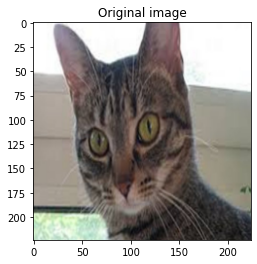

In [5]:
plt.imshow(ims[-1])
plt.title('Original image')
plt.show()

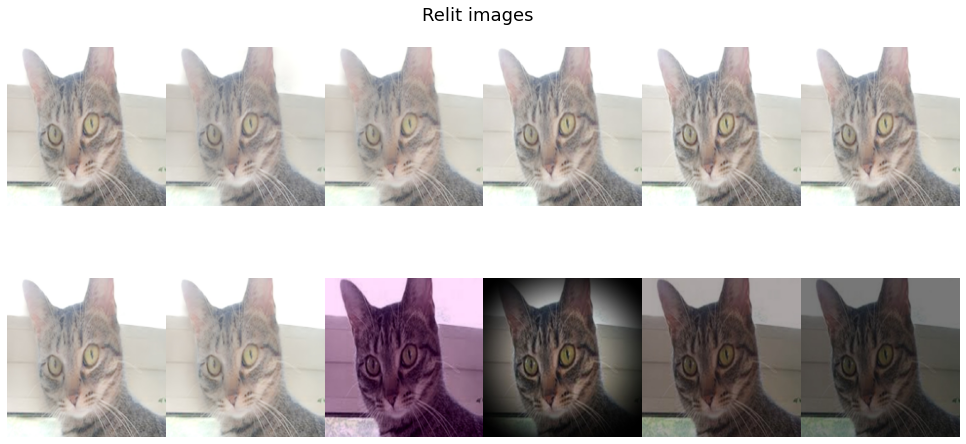

In [6]:
num_cols = (len(ims) - 1) // 2
f, axarr = plt.subplots(2, num_cols, figsize=(14, 7), gridspec_kw = {'wspace':0, 'hspace':0})
f.tight_layout()
f.suptitle('Relit images', fontsize=18)
for i in range(2):
  for j in range(num_cols):
    img = ims[i * num_cols + j]
    axarr[i, j].set_axis_off()
    axarr[i, j].imshow(img)
plt.show()

## **Implementing the projection onto a convex hull**

The projection of a point $ \boldsymbol{x} \in \mathbb{R}^D $ onto a convex set $ C $ is defined as the point in the set which minimizes the distance to $ \boldsymbol{x} $:

$$ P_C(x) = \arg\min_{v \in C} || \boldsymbol{x} - v || \tag{1} $$

Because in our case the convex set is the convex hull of a set of points $\{\boldsymbol{b}_i\}_{i=1}^N \text{ with all } b_i \in \mathbb{R}^D $, every point in the convex hull can be written as a convex combination of the $b_i$s:

$$ \forall \boldsymbol{v} \in C, \exists \alpha_1, \alpha_2, ... \alpha_n \geq 0 \text{ s.t. } \boldsymbol{v} = \sum_{i=1}^N \alpha_i \boldsymbol{b}_i \text{ with } \sum_{i=1}^N \alpha_i = 1 \tag{2} $$

Thus, our optimization problem (1) becomes:

$$ P_C(\boldsymbol{x}) = \arg\min_{\alpha_1, \dots \alpha_n}|| \boldsymbol{x} - \sum_{i=1}^N \alpha_i \boldsymbol{b}_i || \text{, subject to } \sum_{i=1}^N \alpha_i = 1, \tag{3} $$

which we can write in matrix notation as:

$$ P_C(x) = \arg\min_{\boldsymbol{\alpha}} || \boldsymbol{x} - \boldsymbol{B} \boldsymbol{\alpha} ||, \text{ subject to } \boldsymbol{1}^T \boldsymbol{\alpha} = 1 \tag{4} $$

where $\boldsymbol{\alpha} \in \mathbb{R}^N $ contains all $\alpha_i$ stacked and $\boldsymbol{B} \in \mathbb{R}^{D \times N}$ has the $\boldsymbol{b}_i$s as columns. 

Now, in this form, we can easily solve this optimization problem using cvxpy.


In [0]:
def convex_hull_projection(B, x): 
  D, N = B.shape
  alpha = cp.Variable(N)
  objective = cp.Minimize(cp.norm(x - B @ alpha))
  constraints = [ cp.sum(alpha) == 1.0, alpha >= 0 ]
  problem = cp.Problem(objective, constraints)
  problem.solve(solver=cp.SCS, verbose=False)
  proj = np.dot(B, alpha.value)
  return proj, alpha.value

In [8]:
class TestStringMethods(unittest.TestCase):

  # Project the point (2, 2) into the L1 unit ball.
  def test_L1_ball_projection(self):
    B = np.array([[0, 1], [1, 0], [-1, 0], [0, -1]]).T
    x = np.array([2, 2])
    proj, _ = convex_hull_projection(B, x)
    self.assertTrue(np.all(np.isclose(proj, np.array([0.5, 0.5]))))

  # Project the point (2, 2) into the L-inf unit ball.
  def test_Linf_ball_projection(self):
    B = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]]).T
    x = np.array([2, 2])
    proj, _ = convex_hull_projection(B, x)
    self.assertTrue(np.all(np.isclose(proj, np.array([1, 1]))))

unittest.main(argv=['first-arg-is-ignored'], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.046s

OK


## **Image projections**

For each of the 8 relit images, add some random noise and project on the convex hull, visualizing the resulting image as well as the coefficients of the projections.

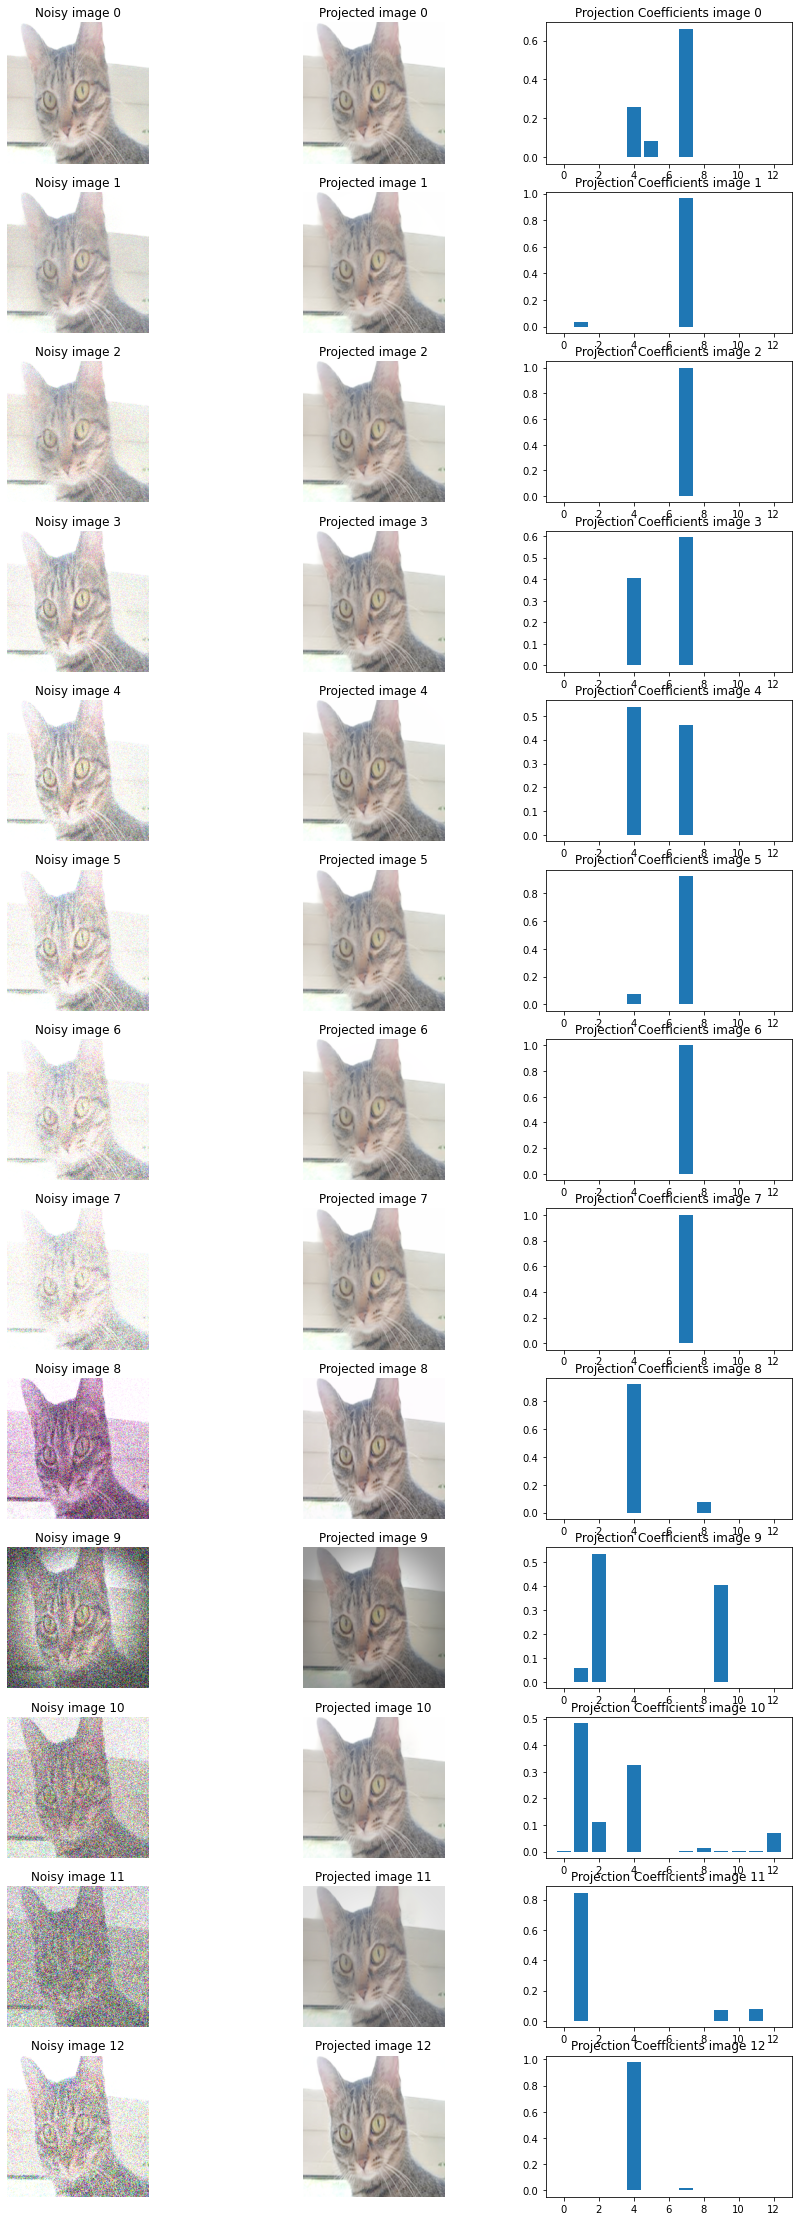

In [9]:
f, axarr = plt.subplots(num_imgs, 3, 
                        figsize=(15, 40), )

for i in range(num_imgs):
  eps = 0.07 * (i + 1)
  noisy = np.array(ims[i]) / 255.0 + np.random.random(im_shape)* eps
  proj, alpha = convex_hull_projection(ims_numpy, noisy.reshape(-1))
  axarr[i, 0].set_axis_off()
  axarr[i, 1].set_axis_off()
  axarr[i, 0].set_title('Noisy image ' + str(i))
  axarr[i, 1].set_title('Projected image ' + str(i))
  axarr[i, 2].set_title('Projection Coefficients image ' + str(i))
  axarr[i, 0].imshow(np.clip(noisy.reshape(im_shape), 0, 1))
  axarr[i, 1].imshow(np.clip(proj.reshape(im_shape), 0, 1))
  axarr[i, 2].bar(np.arange(ims_numpy.shape[1]), alpha)

plt.show()

### **Projecting an arbitrary image**

<BarContainer object of 13 artists>

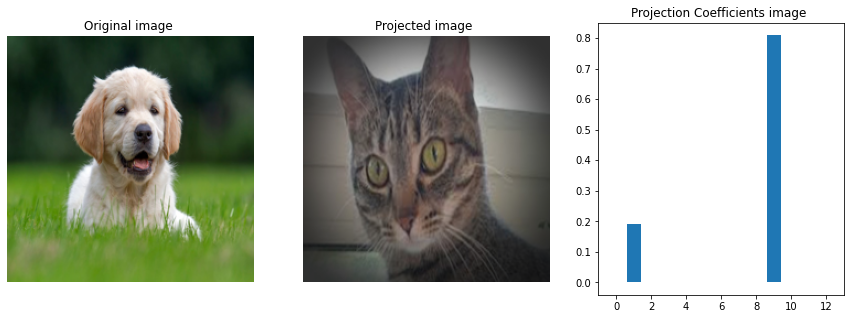

In [10]:
im = Image.open(io.BytesIO(uploaded['dog.jpg'])).resize((224, 224))
im = np.array(im) / 255.0
proj, alpha = convex_hull_projection(ims_numpy, im.reshape(-1))

f, axarr = plt.subplots(1, 3, figsize=(15, 5))
axarr[0].set_axis_off()
axarr[1].set_axis_off()
axarr[0].set_title('Original image ')
axarr[1].set_title('Projected image ')
axarr[2].set_title('Projection Coefficients image ')
axarr[0].imshow(np.clip(im.reshape(im_shape), 0, 1))
axarr[1].imshow(np.clip(proj.reshape(im_shape), 0, 1))
axarr[2].bar(np.arange(ims_numpy.shape[1]), alpha)

## **Loading a classification model**

In [11]:
model = models.alexnet(pretrained=True).double()
model.eval()

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])

inv_normalize = transforms.Normalize(
  mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
  std=[1/0.229, 1/0.224, 1/0.255]
)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


## **Projected gradient descent**

In [0]:
def pgd(model, x, y, eps, alpha, num_iter, proj_type, attack_type):
  ans, loss_hist = [], []
  x_adv = x.clone().detach().to(x.device)
  num_channels = x.shape[1]
  for i in range(num_iter):
    _x_adv = x_adv.clone().detach().requires_grad_(True)
    output = model(_x_adv)
    loss = nn.CrossEntropyLoss()(output, y)
    loss_hist.append(loss.item())
    loss.backward()
    gradients = _x_adv.grad * alpha

    if attack_type == 'targeted':
      x_adv = x_adv - gradients
    else:
      x_adv = x_adv + gradients 

    if proj_type == 'L1':
      x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
    else:
      x_adv = inv_normalize(x_adv[0]).clamp(0, 1)
      x_adv_numpy = x_adv.detach().cpu().numpy().transpose((1, 2, 0))
      old_shape = x_adv_numpy.shape
      projected, _ = convex_hull_projection(ims_numpy, x_adv_numpy.reshape(-1))
      projected = projected.reshape(old_shape)
      x_adv = normalize(torch.tensor(projected.transpose((2, 0, 1))).clamp(0, 1))
      x_adv = x_adv.unsqueeze(0).to(device)
  
  ans.append(x_adv.clone().detach())

  return ans, loss_hist

## **PGD on the L1 eps-norm ball**

In [0]:
def dummy_eval_attack(model, adversarial_imgs, loss_hist, attack_type_txt, orig_img):
  for i in range(len(adversarial_imgs)):
    adversarial_img = adversarial_imgs[i]
    with torch.no_grad():
      output = model(adversarial_img)
      _, predicted = torch.max(output, 1)
      adversarial_img = inv_normalize(adversarial_img[0]).clamp(0, 1)
      adversarial_img = adversarial_img.cpu().numpy().transpose((1, 2, 0))
      adversarial_imgs[i] = adversarial_img

      f, axarr = plt.subplots(1, 2, figsize=(15, 5))

      axarr[0].imshow(adversarial_img)
      axarr[1].plot(loss_hist)
      plt.show()

      print('Label after %s attack: %d' % (attack_type_txt, predicted,))
  print('-----------------------------------------------------------')

In [20]:
input_image = Image.fromarray(np.uint8(255 * np.mean(ims_numpy, axis=1).reshape(im_shape)))

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image).double()
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
  device = 'cuda'
  input_batch = input_batch.to('cuda')
  model.to('cuda')

# eval before attack
with torch.no_grad():
  output = model(input_batch)
  _, orig_label = torch.max(output, 1)

print('Original label: %d' % (orig_label))

Original label: 285


Elapsed time: 3 seconds.


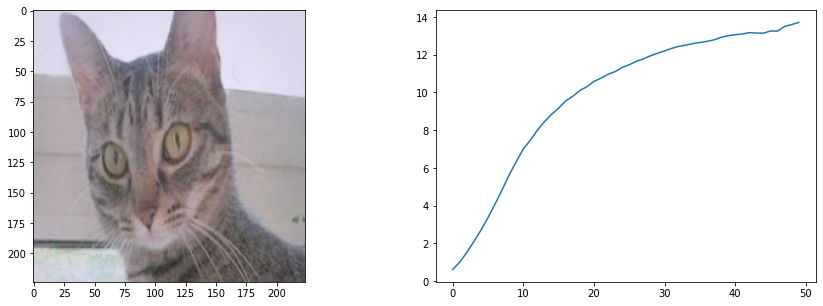

Label after untargeted L1 PGD attack: 281
-----------------------------------------------------------
Elapsed time: 3 seconds.


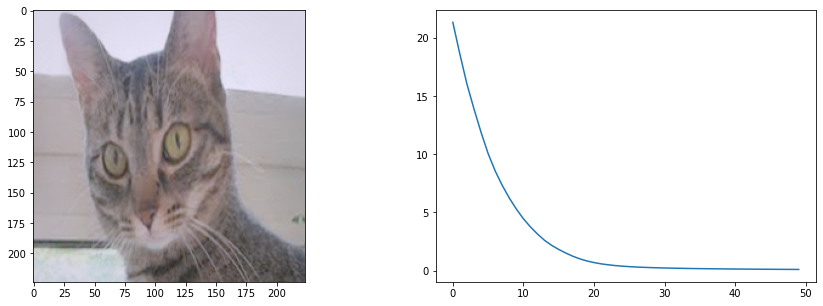

Label after targeted L1 PGD attack: 100
-----------------------------------------------------------
Elapsed time: 232 seconds.


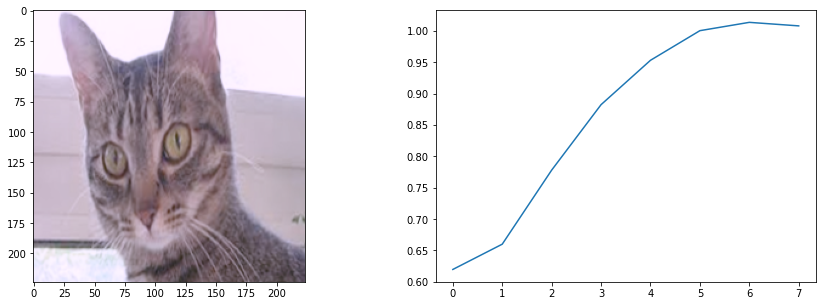

Label after untargeted cvxhull PGD attack: 281
-----------------------------------------------------------
Elapsed time: 223 seconds.


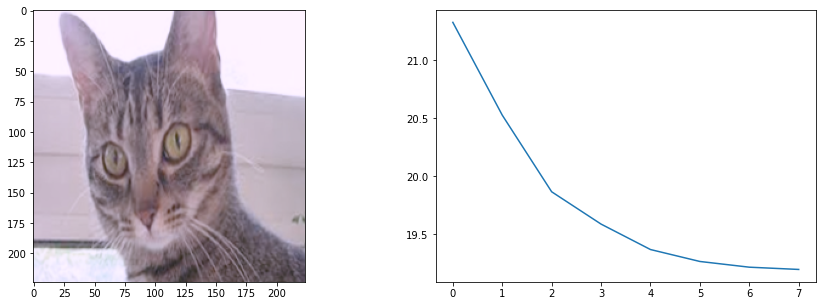

Label after targeted cvxhull PGD attack: 281
-----------------------------------------------------------


In [21]:
target_class = 100
for proj_type in ['L1', 'cvxhull']:
  for attack_type in ['untargeted', 'targeted']:
    if attack_type == 'untargeted':
      y_target = torch.from_numpy(np.array([orig_label.item()]))
    else:
      y_target = torch.from_numpy(np.array([target_class]))
    y_target = y_target.to(device)

    if attack_type == 'untargeted':
      learning_rate = 0.6 if proj_type == 'L1' else 0.01
    else:
      learning_rate = 0.1 if proj_type == 'L1' else 0.01

    num_iterations = 50 if proj_type == 'L1' else 8
    start_time = time.time()
    adversarial_imgs, loss_hist = pgd(model=model, 
                                      x=input_batch, 
                                      y=y_target, 
                                      eps=0.03,
                                      alpha=learning_rate, 
                                      num_iter=num_iterations, 
                                      proj_type=proj_type, 
                                      attack_type=attack_type)
    end_time = time.time()

    print('Elapsed time: %ld seconds.' % (end_time - start_time))
    dummy_eval_attack(model, 
                      adversarial_imgs,
                      loss_hist, 
                      attack_type + ' ' + proj_type + ' PGD',
                      input_image)
    

## **Conclusions**



*   **L1 adversarial attacks are easy and quite fast**
*   **Projections at each step are very expensive**
*   **The space defined by a few images is maybe not enough for adversarial attacks (the curse of dimensionality)** 

<img src="https://drive.google.com/uc?id=1iczd_v2k2cadkFgDRH-O_pKnszljktmI" width="700">




*   **Projections can be scary if you have bugs in your code.**






In [23]:
uploaded = files.upload()

Saving cat_gone_wrong.jpg to cat_gone_wrong.jpg


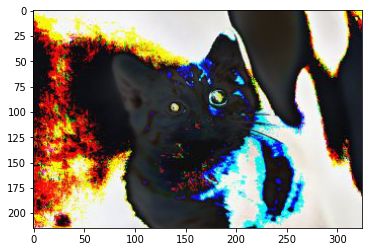

In [24]:
plt.imshow(Image.open(io.BytesIO(uploaded['cat_gone_wrong.jpg'])))